In [1]:
#!/usr/bin/env python
# coding: utf-8

# Loading required libraries and python modeules
# Pandas and numpy for data processing and liner algebra
import numpy as np  
import pandas as pd  

# For plotting 
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bar for python and CLI
from tqdm import tqdm

## Importing sklearn modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

## Suprass some hectic warnings 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Use Keras with TensorFlow backend 
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Dropout

from utils import *

Using TensorFlow backend.


193

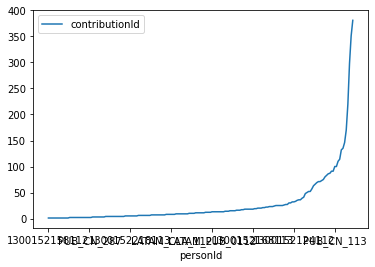

In [4]:
data = "data.json" 
labels = "ground-truth.json" 
persons = "persons.json"

df, df_ground_truth, df_person, d_labels, author_mapping_dict, id_author_mapping_dict = prepareData(data, labels, persons)

Number of persons to be disambiguated: 193
Number of unique labels: 187


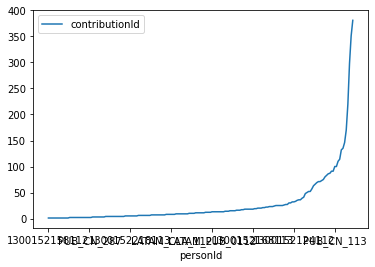

In [9]:
## Some EDA

# contribution distribution
df_ground_truth.groupby("personId").count().sort_values(by=['contributionId']).plot()
    
# Unique persons
n_persons = len(df_person)
print("Number of persons to be disambiguated: " + str(n_persons))

# Let's see how many unique labels we got
print("Number of unique labels: " + str(len(np.unique(d_labels))))

In [10]:
# Feature engineering and feature vector creation: let's see what's we got to be used as features for our model 
df['features'].head()

# Using CountVectorizer, we do lose any order with those feature columns with below method however has no effect anyway
cv = CountVectorizer()
cv_vec = cv.fit_transform(df['features'].values.tolist())

# ### Train and test set creation: we use 80% for training an estimator, the rest 20% for evaluation the trained model. 
X_train, X_test, y_train, y_test = train_test_split(cv_vec, d_labels, test_size=0.2, random_state=42)

In [11]:
estimator = initModel(X_train, X_test)
cv_model = estimator.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/rkarim/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   22.8s finished


In [12]:
# Step-3: evaluating the trained RF model on test set: now that the RF model is trained, we evaluate the performence on the 20% held-out test set. This is, hopefully, give some good basis or justification why RF was a good and reasonable choice. To upport the arument, I'll further use some sort of AutoML library such as PyCaret. 
y_pred = cv_model.predict(X_test)

## Calculating metrics for each label and their unweighted mean. This does not take label imbalance into account.
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# As the dataset is not balanced, let's use MCC too 
mcc = matthews_corrcoef(y_test, y_pred)

print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F1: " + str(f1))
print("MCC: " + str(mcc))

Precision: 0.7312604776720076
Recall: 0.7197925867328852
F1: 0.7129612941420553
MCC: 0.8554765521314335


/home/rkarim/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rkarim/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
# Step-5: Naive validation on riginal data for output reasons + sharing
d_vec = cv.transform(df['features'].values.tolist())
np.argmax(cv_model.predict_proba(d_vec), axis=1)
y_res = [id_author_mapping_dict[i] for i in d_labels]
df["pred"] = y_res

df.to_csv("full_output_matches.tsv", sep ='\t', index=False)
df[["index", "contribution_id", "features", "personId", "pred"]].to_csv("output_matches.tsv", sep ='\t', index=False)

## Let's randomly checks some rows to see how the model predicted
sm_df = pd.read_csv("output_matches.tsv", sep ='\t')
sm_df.tail()

,index,contribution_id,features,personId,pred
5083,5082,5f6efcf8aa7f0f0018f7c757,哈尔滨血液病肿瘤研究所,ASSO_CN_21,ASSO_CN_21
5084,5083,5f72ded3458b3300181bf1f3,"Eric Winer boston, usa Cancer Therapy,Oncolog...",10004446,10004446
5085,5084,5f72e52d2d48e3004a6cc74c,"Eric Winer boston, usa Topic: Solid Tumors,To...",10004446,10004446
5086,5085,5f7c33b031f1910018a74015,S Vengojaya Prasad,1300152124112,1300152124112
5087,5086,5f7ceb745bccb8001963d03a,Scott McKenzie,1300152213113,1300152213113
